## The goal of this project is to predict which driver signups are most likely to start driving.

Using the driver signup information the goal is to predict whether a signup will start to drive, and offer suggestions to operationalize those insights.

## Exploratory Data Analysis (EDA) and Feature Engineering

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
#Reading the dataset
df = pd.read_csv("ds_challenge_data.csv")

In [3]:
#printing first 5 rows
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [4]:
#checking the shape of the data
df.shape

(54681, 11)

In [5]:
#checking the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    54681 non-null  int64  
 1   city_name             54681 non-null  object 
 2   signup_os             47824 non-null  object 
 3   signup_channel        54681 non-null  object 
 4   signup_date           54681 non-null  object 
 5   bgc_date              32896 non-null  object 
 6   vehicle_added_date    13134 non-null  object 
 7   vehicle_make          13223 non-null  object 
 8   vehicle_model         13223 non-null  object 
 9   vehicle_year          13223 non-null  float64
 10  first_completed_date  6137 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.6+ MB


#### We notice that some of the fields have Nan values

In [6]:
#converting date columns to pandas date time

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['bgc_date'] = pd.to_datetime(df['bgc_date'])
df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date'])
df['first_completed_date'] = pd.to_datetime(df['first_completed_date'])

In [7]:
#printing the amount of Nan values
np.round(df.isnull().sum(axis = 0)/len(df),2)

id                      0.00
city_name               0.00
signup_os               0.13
signup_channel          0.00
signup_date             0.00
bgc_date                0.40
vehicle_added_date      0.76
vehicle_make            0.76
vehicle_model           0.76
vehicle_year            0.76
first_completed_date    0.89
dtype: float64

### Observations :

1. There's a significant number of missing values for vehicle_added_date,vehicle_make,vehicle_model,vehicle_year and first_completed_date.

2. If someone is truely going to become a driver, then there could possibly be no number of missing values in bgc_date,vehicle_make,vehicle_model and vehicle_year

3. For rows with several missing values, there should be less tendency to become drivers

4. This is an example of MNAR - missing not at random

In [8]:
#creating flags for each of the relevant columns to signify whether there is a missing value or not
#Using one flag to represent 'vehicle_make', 'vehicle_model' and 'vehicle_year' since they all have the same number of NaNs.

df['signup_os_flag'] = df['signup_os'].notnull().astype(int)
df['bgc_date_flag'] = df['bgc_date'].notnull().astype(int)
df['vehicle_added_date_flag'] = df['vehicle_added_date'].notnull().astype(int)
df['vehicle_make_flag'] = df['vehicle_make'].notnull().astype(int)

The time difference between signing up and consenting to their background check would be a good indicator of whether or not they are willing to become a driver. Let's compute the time difference between 'bgc_date' and 'signup_date' and assign that to a new feature.

In [9]:
# Compute time differences between bgc_date and sign_up date, replace negative time differences with 0 and replace NaN values with -1
df['signup_bgc_delta'] = (df['bgc_date'] - df['signup_date']) / np.timedelta64(1, 'D')
df['signup_bgc_delta'] = df['signup_bgc_delta'].clip(lower=0).fillna(-1)

The time difference between Vehicle_added_date and sign_up_date tells how much the person is willing to becaome a driver.

In [10]:
# Compute time differences between Vehicle_added_date and sign_up date, replace negative time differences with 0 and replace NaN values with -1
df['signup_vehicle_delta'] = (df['vehicle_added_date'] - df['signup_date']) / np.timedelta64(1, 'D')
df['signup_vehicle_delta'] = df['signup_vehicle_delta'].clip(lower=0).fillna(-1)

Any time difference values that were less than 0 days (meaning the vehicle registration or background check was completed before they even signed up) was converted to 0 days. Additionally, we convert the NaN values to -1 since 0 days is reserved to signify eager applicants who signed up and did their background check and/or vehicle registration in the same day.


In [11]:
#checking if there are any zero elements in the columns.

for i in df.columns[:10]:
    try:
        print(i+' --', df[df[i] == 0][i].count())
    except:
        print(i+' --', 0)

id -- 0
city_name -- 0
signup_os -- 0
signup_channel -- 0
signup_date -- 0
bgc_date -- 0
vehicle_added_date -- 0
vehicle_make -- 0
vehicle_model -- 0
vehicle_year -- 4


 'vehicle_year' has 4 rows that are zero,replacing 0 with Nan

In [12]:
df['vehicle_year']=df['vehicle_year'].replace(0, np.NaN)

(array([  11.,   24.,  198.,  601.,  819., 1920., 1158., 1824., 3106.,
        3558.]),
 array([1995. , 1997.2, 1999.4, 2001.6, 2003.8, 2006. , 2008.2, 2010.4,
        2012.6, 2014.8, 2017. ]),
 <BarContainer object of 10 artists>)

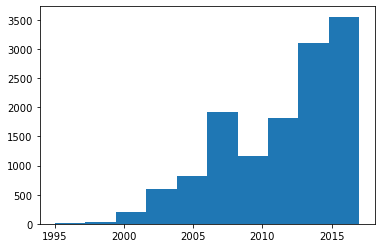

In [13]:
#histogram plot
plt.hist([df['vehicle_year']])

Observation :

1. As per the above plot,most of the vehicles registered are new vehicles

In [14]:
#breaking the time stamps into  month, day of month, day of week, etc..
print('Breaking signup datetime')
print('Year:', pd.to_datetime(df['signup_date']).dt.year.unique())
print('Month:', pd.to_datetime(df['signup_date']).dt.month.unique())
print('Week:',pd.to_datetime(df['signup_date']).dt.dayofweek.unique(),'\n')
print('Day:',pd.to_datetime(df['signup_date']).dt.day.unique())


Breaking signup datetime
Year: [2016]
Month: [1]
Week: [5 3 0 4 6 1 2] 

Day: [ 2 21 11 29 10 18 14 26  5 25  4 12 13 15 24 16  7  6  8 28 20  9 17  1
 22 27 23 19 30  3]


In [15]:
print('Breaking Background check datetime')
print('Year:', pd.to_datetime(df['bgc_date']).dt.year.unique())
print('Month:', pd.to_datetime(df['bgc_date']).dt.month.unique())
print('Day:', pd.to_datetime(df['bgc_date']).dt.day.unique(),'\n')

Breaking Background check datetime
Year: [  nan 2016.]
Month: [nan  1.  2.  3.]
Day: [nan 11.  3. 25. 18. 16.  5.  9. 12. 20.  7. 17. 15. 26. 27.  8. 21.  2.
 31. 22. 10. 24. 30. 23.  4. 29. 19.  6. 14. 28.  1. 13.] 



In [16]:
print('Breaking vehicle addedd datetime')
print('Year:', pd.to_datetime(df['vehicle_added_date']).dt.year.unique())
print('Month:', pd.to_datetime(df['vehicle_added_date']).dt.month.unique())
print('Day:', pd.to_datetime(df['vehicle_added_date']).dt.day.unique())

Breaking vehicle addedd datetime
Year: [  nan 2016.]
Month: [nan  2.  1.  3.]
Day: [nan  3. 26. 22. 21. 24. 12. 17.  6. 28. 19. 25.  1. 15. 11. 30. 18. 14.
 10. 23. 16. 20.  8.  4. 29.  2.  9. 27.  7.  5. 13. 31.]


### Observations :

1. There is  no variation in 'signup_year' and 'signup_month' so we will not use them as features since they provide no insight.

2. We will also not use 'bgc_year' and 'vehicle_added_year' as they only have two values: 2016 and NaN. 

3. The NaN values are already captured by both the missing value flags.

4. The reason for breaking the dates into both day of week and day of month is these features may capture time sensitive information specific to different periods. For instance, the day of month feature would capture promotional campaigns that target driver signups toward the beginning or end of each month, and the day of week feature would capture promotional campaigns that target drivers on weekends or working weekdays.

### creating timestamp-derived features and replace any NaNs with -1.
#### Extract month, day of month, day of week from date columns

In [17]:
df['signup_day'] = pd.to_datetime(df['signup_date']).dt.day.fillna(-1)
df['signup_day_of_week'] = pd.to_datetime(df['signup_date']).dt.dayofweek.fillna(-1)
df[['signup_day', 'signup_day_of_week']].head(10)

,signup_day,signup_day_of_week
0,2,5
1,21,3
2,11,0
3,29,4
4,10,6
5,18,0
6,14,3
7,26,1
8,5,1
9,25,0


In [18]:
df['bgc_month'] = pd.to_datetime(df['bgc_date']).dt.month.fillna(-1)
df['bgc_day'] = pd.to_datetime(df['bgc_date']).dt.day.fillna(-1)
df['bgc_day_of_week'] = pd.to_datetime(df['bgc_date']).dt.dayofweek.fillna(-1)
df[['bgc_month', 'bgc_day','bgc_day_of_week']].head(10)

,bgc_month,bgc_day,bgc_day_of_week
0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0
2,1.0,11.0,0.0
3,2.0,3.0,2.0
4,1.0,25.0,0.0
5,1.0,18.0,0.0
6,1.0,16.0,5.0
7,2.0,5.0,4.0
8,-1.0,-1.0,-1.0
9,-1.0,-1.0,-1.0


In [19]:
df['vehicle_added_month'] = pd.to_datetime(df['vehicle_added_date']).dt.month.fillna(-1)
df['vehicle_added_day'] = pd.to_datetime(df['vehicle_added_date']).dt.day.fillna(-1)
df['vehicle_added_day_of_week'] = pd.to_datetime(df['vehicle_added_date']).dt.dayofweek.fillna(-1)
df[['vehicle_added_month', 'vehicle_added_day','vehicle_added_day_of_week']].head(10)

,vehicle_added_month,vehicle_added_day,vehicle_added_day_of_week
0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0
3,2.0,3.0,2.0
4,1.0,26.0,1.0
5,1.0,22.0,4.0
6,1.0,21.0,3.0
7,-1.0,-1.0,-1.0
8,-1.0,-1.0,-1.0
9,-1.0,-1.0,-1.0


In [20]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,...,signup_bgc_delta,signup_vehicle_delta,signup_day,signup_day_of_week,bgc_month,bgc_day,bgc_day_of_week,vehicle_added_month,vehicle_added_day,vehicle_added_day_of_week
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,...,-1.0,-1.0,2,5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,...,-1.0,-1.0,21,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,...,0.0,-1.0,11,0,1.0,11.0,0.0,-1.0,-1.0,-1.0
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,...,5.0,5.0,29,4,2.0,3.0,2.0,2.0,3.0,2.0
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,...,15.0,16.0,10,6,1.0,25.0,0.0,1.0,26.0,1.0


### Categorical features :

#### Analysing the Categorical features in detail:

In [21]:
df['city_name'].value_counts(normalize=True, dropna=False)

Strark     0.540535
Berton     0.367897
Wrouver    0.091567
Name: city_name, dtype: float64

In [22]:
df['signup_os'].value_counts(normalize=True, dropna=False)

ios web        0.304164
android web    0.273294
NaN            0.125400
windows        0.123919
mac            0.106509
other          0.066714
Name: signup_os, dtype: float64

In [23]:
df['signup_channel'].value_counts(normalize=True, dropna=False)

Paid        0.437775
Referral    0.316673
Organic     0.245551
Name: signup_channel, dtype: float64

#### One hot encoding on City Name, Signup OS and Signup Channel

In [24]:

dum_city_name = pd.get_dummies(df['city_name'])
dum_signup_os = pd.get_dummies(df['signup_os'])
dum_signup_channel = pd.get_dummies(df['signup_channel'])

print(dum_city_name.head(5))
print('-'*50)
print(dum_signup_os.head(5))
print('-'*50)
print(dum_signup_channel.head(5))

   Berton  Strark  Wrouver
0       0       1        0
1       0       1        0
2       0       0        1
3       1       0        0
4       0       1        0
--------------------------------------------------
   android web  ios web  mac  other  windows
0            0        1    0      0        0
1            0        0    0      0        1
2            0        0    0      0        1
3            1        0    0      0        0
4            1        0    0      0        0
--------------------------------------------------
   Organic  Paid  Referral
0        0     1         0
1        0     1         0
2        1     0         0
3        0     0         1
4        0     0         1


#### Unique values in Vehicle Make feature

In [25]:
df['vehicle_make'].nunique()

46

In [26]:
df['vehicle_make'].value_counts()

Toyota           3219
Honda            1845
Nissan           1311
Ford              778
Hyundai           677
Chevrolet         665
Kia               584
Volkswagen        503
Dodge             393
Mercedes-Benz     348
Lexus             335
BMW               330
Mazda             292
Subaru            221
Jeep              203
Chrysler          202
Acura             190
Scion             164
Infiniti          147
Audi              144
Mitsubishi        113
GMC                89
Cadillac           86
Lincoln            70
Volvo              57
Buick              46
Saturn             30
Pontiac            30
Land Rover         20
Mini               20
Jaguar             15
Tesla              13
Suzuki             12
Fiat               11
Porsche            10
Mercury             9
Autobot             8
Hummer              7
Saab                7
Bike                6
Bicycle             5
Bentley             2
Maserati            2
Isuzu               2
Walker              1
Oldsmobile

### Observation

There are so many different vehicle manufacturers, instead of dummifying them we will convert them to numeric values using the LabelEncoder() method.

In [27]:
# Convert NaN values to 'None' so that LabelEncoder() can handle them without throwing an error
df['vehicle_make'].replace(np.NaN,'None', inplace=True)

In [28]:
le = LabelEncoder()
df['vehicle_make'] = le.fit_transform(df['vehicle_make'])

In [29]:
df['vehicle_year'].nunique()

23

In [30]:
df['vehicle_year'].value_counts()

2015.0    2402
2014.0    1655
2013.0    1451
2016.0    1150
2012.0    1122
2007.0     711
2011.0     702
2008.0     659
2010.0     645
2006.0     550
2009.0     513
2005.0     450
2004.0     369
2003.0     350
2002.0     251
2001.0     169
2000.0      29
1999.0      14
1998.0      10
1997.0       6
2017.0       6
1996.0       4
1995.0       1
Name: vehicle_year, dtype: int64

In [31]:
# Convert None values to 0 so that LabelEncoder() can handle them without throwing an error
df['vehicle_year'].replace('None',0, inplace=True)

In [32]:
le = LabelEncoder()
df['vehicle_year'] = le.fit_transform(df['vehicle_year'])

In [33]:
df['vehicle_model'].nunique()

368

In [34]:
df['vehicle_model'].value_counts()

Civic                  689
Corolla                688
Camry                  683
Accord                 595
Prius V                522
                      ... 
5-Sep                    1
ML Class                 1
6-series Gran Coupe      1
FR-S                     1
Prizm                    1
Name: vehicle_model, Length: 368, dtype: int64

In [35]:
df['vehicle_model'].unique()[:100]

array([nan, 'Corolla', 'Sonata', 'DTS', 'Prius V', 'Optima', 'Durango',
       'C-Class', 'G Sedan', 'Civic', '500X', 'Escalade', 'RDX', 'ES',
       'Prius', 'CR-V', 'CT', 'Terrain', 'G6', 'Civic Hybrid', 'Accord',
       'Versa', 'Odyssey', 'Grand Cherokee', 'GTI', 'F-150', 'A4',
       'Insight Hybrid', 'Elantra', 'Camry', 'Sentra', 'Malibu', 'Soul',
       'Altima', 'Journey', 'Compass', '3-series', 'Cruze', 'Forester',
       'Century', 'MAZDA3', 'XV Crosstrek', 'Charger', 'Flex', '7-series',
       'RAV4', 'Traverse', 'Avenger', 'Jetta', 'Expedition', 'IS',
       'Town and Country', 'Sienna', 'iM', 'Freestyle', 'VUE', 'Avalon',
       'Tacoma', 'MAZDA6', 'Dart', 'Suburban', 'Xterra', 'Forte',
       'Highlander', 'Santa Fe', 'Focus', 'Q50', 'Impreza', 'xB',
       'Fiesta', 'Ridgeline', '5-series', 'Pilot', 'Fusion', 'Regal',
       'Caravan', 'E-Class', 'Rogue', '200', 'S80', 'Enclave', 'Nitro',
       'Cavalier', 'Pathfinder', 'Escape', 'Murano', 'Sportage', 'HR-V',
       'Ma

Observation :

1. We can see from the above model names, some of these model names exclusively contain alphabetic characters and some contain a mixture of alphabetic and numeric characters (i.e., alphanumeric)

2. Some findings suggest that car names with alphanumeric characters (e.g., CX-9) signify luxury and fanciness, whereas car names with just alphabetic characters (e.g., Versa) signify value, cheaper and mass-market cars.  [See this article for details](http://www.atlasobscura.com/articles/how-cars-get-named)

3. Let's create a flag for the cars that contain numbers in them.  The reason would be, the owners of higher-end cars to be less likely to follow through and complete their first drive than owners of more common cars.

#### Checking if a car has a number in it

In [36]:
def Alphanumeric(s):
    try:
        return int(any(i.isdigit() for i in s))
    except:
        return -1

In [37]:
df['luxury_vehicle'] = df['vehicle_model'].apply(Alphanumeric)
df['luxury_vehicle'].value_counts()

-1    41458
 0    11837
 1     1386
Name: luxury_vehicle, dtype: int64

#### Replaceing NaN values to 'None' 

In [38]:
df['vehicle_model'].replace(np.NaN, 'None', inplace=True)
le = LabelEncoder()
df['vehicle_model'] = le.fit_transform(df['vehicle_model'])

In [39]:
#Encoding 'first_completed_date'
df['first_drive'] = df['first_completed_date'].isnull().astype(int)

<AxesSubplot:>

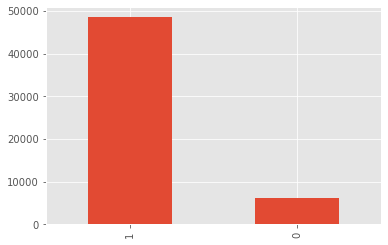

In [94]:
df['first_drive'].value_counts().plot(kind='bar')

we are defining 1 to be the applicant who signs up and does not complete first trip as a driver, and defining 0 to be the applicant who signs up and does complete first trip as a driver.

#### Question 1 - What fraction of the driver signups took a first trip?

In [41]:
df['first_drive'].value_counts()

1    48544
0     6137
Name: first_drive, dtype: int64

In [42]:
df['first_drive'].value_counts(normalize=True)

1    0.887767
0    0.112233
Name: first_drive, dtype: float64

###### Ans : 11.2% of driver applicants who signed up actually took a first trip as a driver.

#### Q2 : Build a predictive model to help determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [44]:
df.columns

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date', 'signup_os_flag',
       'bgc_date_flag', 'vehicle_added_date_flag', 'vehicle_make_flag',
       'signup_bgc_delta', 'signup_vehicle_delta', 'signup_day',
       'signup_day_of_week', 'bgc_month', 'bgc_day', 'bgc_day_of_week',
       'vehicle_added_month', 'vehicle_added_day', 'vehicle_added_day_of_week',
       'luxury_vehicle', 'first_drive'],
      dtype='object')

In [46]:
columns =['vehicle_make', 'vehicle_model','vehicle_year','bgc_date_flag','vehicle_added_date_flag', \
           'signup_os_flag', 'vehicle_make_flag','signup_bgc_delta', 'signup_vehicle_delta',\
           'signup_day', 'signup_day_of_week', 'bgc_month', 'bgc_day','bgc_day_of_week', \
           'vehicle_added_month', 'vehicle_added_day','vehicle_added_day_of_week', 'luxury_vehicle']

In [47]:
X = pd.concat([dum_city_name,dum_signup_os,dum_signup_channel,df[columns]],axis=1)
y = df['first_drive']

In [48]:
X.head()

,Berton,Strark,Wrouver,android web,ios web,mac,other,windows,Organic,Paid,...,signup_vehicle_delta,signup_day,signup_day_of_week,bgc_month,bgc_day,bgc_day_of_week,vehicle_added_month,vehicle_added_day,vehicle_added_day_of_week,luxury_vehicle
0,0,1,0,0,1,0,0,0,0,1,...,-1.0,2,5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
1,0,1,0,0,0,0,0,1,0,1,...,-1.0,21,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
2,0,0,1,0,0,0,0,1,1,0,...,-1.0,11,0,1.0,11.0,0.0,-1.0,-1.0,-1.0,-1
3,1,0,0,1,0,0,0,0,0,0,...,5.0,29,4,2.0,3.0,2.0,2.0,3.0,2.0,0
4,0,1,0,1,0,0,0,0,0,0,...,16.0,10,6,1.0,25.0,0.0,1.0,26.0,1.0,0


#### Scale and normalizing the matrix

In [49]:
sc = StandardScaler()
Xt = sc.fit_transform(X)

In [50]:
Xt[0]

array([-0.7629035 ,  0.92196454, -0.31748574, -0.61324765,  1.51251394,
       -0.34526081, -0.26736334, -0.37609389, -0.57050107,  1.13325904,
       -0.68075571,  0.2332971 ,  0.25808672,  0.4634619 , -1.22883271,
       -0.56224897,  0.37865537, -0.56475596, -0.67890136, -0.39842187,
       -1.45890516,  1.05169642, -1.1718774 , -0.95209952, -0.96681697,
       -0.54711426, -0.49041182, -0.48727457, -0.53813397])

### Deciding on performance metrics :

As this is a binary classification problem,some of the possible performace metrics we can consider are accuracy,precision,recall,f1 score and ROC AUC score

Applying 5 fold cross validation to different classfication algorithms

In [41]:
def performance(cv,scoring):
    
    kn = KNeighborsClassifier()
    s = cross_val_score(kn, Xt, y, cv=cv, scoring=scoring)
    print("{} Score:\t{:0.3} ± {:0.3}".format("K Nearest Neighbors", s.mean().round(3), s.std().round(3)))
    
    lr = LogisticRegression(class_weight='balanced',random_state=99)
    s = cross_val_score(lr, Xt, y, cv=cv, scoring=scoring)
    print("{} Score:\t{:0.3} ± {:0.3}".format("Logistic Regression", s.mean().round(3), s.std().round(3)))

    dt = DecisionTreeClassifier(class_weight='balanced',random_state=99)
    s = cross_val_score(dt, Xt, y, cv=cv, scoring=scoring)
    print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

    rf = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=99)
    s = cross_val_score(rf, Xt, y, cv=cv, scoring=scoring)
    print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

    gb = GradientBoostingClassifier(n_estimators=100,random_state=99)
    s = cross_val_score(gb, Xt, y, cv=cv, scoring=scoring)
    print("{} Score:\t{:0.3} ± {:0.3}".format("Gradient Boosting", s.mean().round(3), s.std().round(3)))


In [42]:
cv = StratifiedKFold(n_splits=5,random_state=99, shuffle=True)
scoring = 'accuracy'
print("Accuracy :")
performance(cv,scoring)

Accuracy :
K Nearest Neighbors Score:	0.932 ± 0.002
Logistic Regression Score:	0.926 ± 0.002
Decision Tree Score:	0.915 ± 0.001
Random Forest Score:	0.938 ± 0.002
Gradient Boosting Score:	0.944 ± 0.001


In [43]:
scoring = 'f1'
print("F1 score:")
performance(cv,scoring)

F1 score:
K Nearest Neighbors Score:	0.961 ± 0.001
Logistic Regression Score:	0.957 ± 0.001
Decision Tree Score:	0.952 ± 0.0
Random Forest Score:	0.965 ± 0.001
Gradient Boosting Score:	0.968 ± 0.001


In [44]:
scoring = 'precision'
print("Precision :")
performance(cv,scoring)

Precision :
K Nearest Neighbors Score:	0.967 ± 0.001
Logistic Regression Score:	0.992 ± 0.002
Decision Tree Score:	0.95 ± 0.001
Random Forest Score:	0.967 ± 0.001
Gradient Boosting Score:	0.974 ± 0.001


In [45]:
scoring = 'recall'
print("Recall :")
performance(cv,scoring)

Recall :
K Nearest Neighbors Score:	0.955 ± 0.002
Logistic Regression Score:	0.924 ± 0.002
Decision Tree Score:	0.955 ± 0.002
Random Forest Score:	0.963 ± 0.002
Gradient Boosting Score:	0.963 ± 0.001


### Observations :

Recall is appropriate evaluation metric

1.Among 6 algorithms gradient boosting model performs well with all the performance metrics

2.Recall is the best performance metric for this case. Based on the assumptions, recall tells us of all the applicants who actually signedup and did not complete their first trip as driver, what % of these applications did we correctly predict.

3.By correctly predicting the drivers that are most likely to start driving,the company can take appropriate action by giving promotions,incentives and email campaigns

4.In terms of recall, the random forest model performed equal to gradient boosting model so,if computational time and complexity are factors then random forest may be preferred.

### Modelling :

In [55]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.20, random_state=99)

In [56]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=99)
y_pred = gb.fit(X_train,y_train).predict(X_test)

In [57]:
print('Gradient Boosting Classification Report \n')
print(classification_report(y_test, y_pred) + '\n')
print('Gradient Boosting Confusion Matrix \n')
confusion_matrix = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(confusion_matrix, index=['true_driver', 'true_not_driver'],columns=['predicted_driver','predicted_not_driver'])
print(confusion)


Gradient Boosting Classification Report 

              precision    recall  f1-score   support

           0       0.74      0.81      0.78      1237
           1       0.98      0.96      0.97      9700

    accuracy                           0.95     10937
   macro avg       0.86      0.89      0.87     10937
weighted avg       0.95      0.95      0.95     10937


Gradient Boosting Confusion Matrix 

                 predicted_driver  predicted_not_driver
true_driver                  1008                   229
true_not_driver               352                  9348


In [58]:
features = pd.Series(gb.feature_importances_, index = pd.Series(X.columns).apply(lambda x: x.lower()))
features.sort_values(ascending=True,inplace=True)

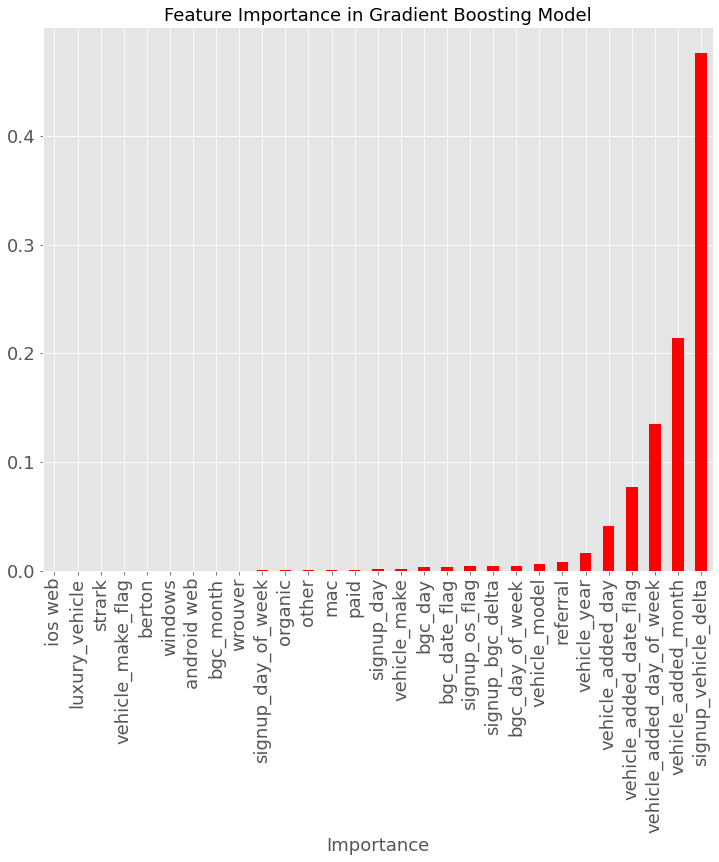

In [93]:
plt.style.use('ggplot')
features.plot(kind = "bar", color='r', figsize=(12,10),fontsize=18)
plt.xlabel('Importance',fontsize=18)
plt.title("Feature Importance in Gradient Boosting Model", fontsize=18);

#### Observation :

1. *signup_vehicle_delta* ,*vehicle_added_month* and *vehicle_added_day_of_week* are the key features

2. We can further improve the model performance by ensembling or stacking to better allow for generalization to the unseen data.

3. I can further extend by applying XGBoost or LightGBM and they may have provide improvement in model performance.

4. Due to the time constraint,i intentionally ignored to use regularization techniques like Lasso and Ridge .

5. SelectKBest, RFECV(recursive feature elimination and cross-validated selection) can also be used to fine tune the hyper parameters which result in improved performace.

5. Also all the models I used were straight out of the box with default values and no hyperparameter tuning was employed.

  #### Question 3 - *Briefly discuss how we might leverage the insights gained from the model to generate more first trips 

In [63]:
drivers_signups = df[df['first_drive'] == 0]['signup_vehicle_delta']
not_drivers_signups = df[df['first_drive'] == 1]['signup_vehicle_delta']

<AxesSubplot:title={'center':'Drivers Signups'}, xlabel='Days', ylabel='Count'>

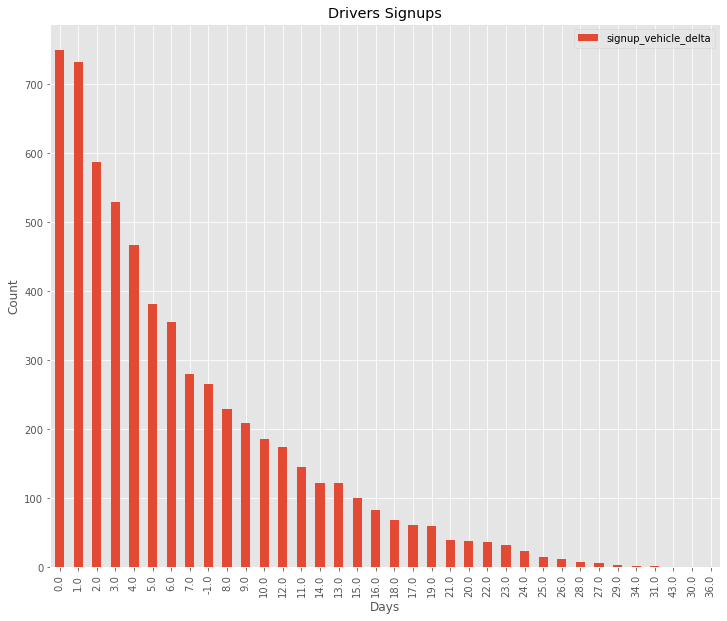

In [89]:
drivers_signups.value_counts().plot(kind='bar', figsize=(12,10),xlabel='Days',ylabel='Count', legend=True, title='Drivers Signups')

<AxesSubplot:title={'center':'Drivers with no Signups'}, xlabel='Days', ylabel='Count'>

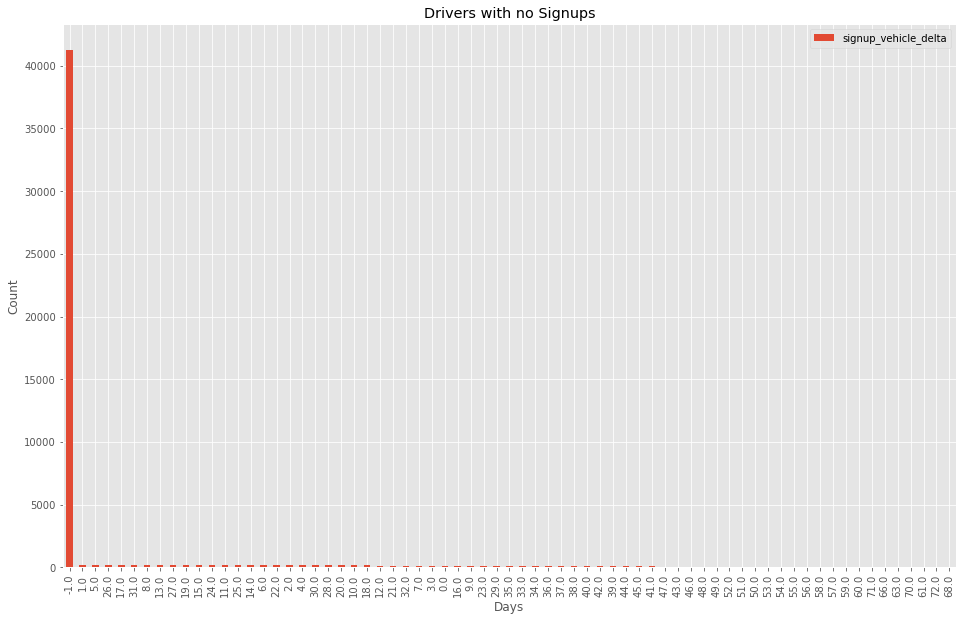

In [92]:
not_drivers_signups.value_counts().plot(kind='bar', figsize=(16,10),xlabel='Days',ylabel='Count', legend=True, title='Drivers with no Signups')

1. Drivers who did not complete the vehicle registration with in 30 days of signup are most likely never take up their first trip as  a driver.

2. We can leverage on the model to identify these users and provide additional assistance to complete their vehicle registration 

3. Service provider can also offer perks to encorage the drivers to register their vehicles as soon as they signup. 